In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold

import optuna
from optuna.samplers import TPESampler

## Read data

In [7]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

## Preprocess data

In [19]:
encoder = LabelEncoder()
scaler = MinMaxScaler()

train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.transform(test['Sex'])

cat_cols = ['Sex']
target = 'Rings'
continuous_cols = [col for col in train.columns if col not in cat_cols + [target]]

train[continuous_cols] = scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = scaler.transform(test[continuous_cols])

X = train.drop(columns=['Rings'], axis=1).values
y = train['Rings'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, random_state=24)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 85
# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define network

In [34]:
class SAINTModel(nn.Module):
    """
    Self-Attention and Intersample Attention Transformer (SAINT) model.
    """
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, dropout):
        """
        Initialize the SAINT model.
        
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Hidden dimension size.
            num_heads (int): Number of attention heads.
            num_layers (int): Number of transformer layers.
            dropout (float): Dropout probability.
        """
        super(SAINTModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        self.head_dim = hidden_dim // num_heads
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.transformer_layers = nn.ModuleList([nn.TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Perform forward pass through the SAINT model.
        
        Args:
            x (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Output predictions.
        """
        # Reshape the input tensor
        x = x.view(x.size(0), -1)
        
        # Pass through the input layer
        x = self.input_layer(x)
        
        # Pass through the transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
        
        # Pass through the output layer
        output = self.output_layer(x)
        
        return output.squeeze()


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [36]:
# Define hyperparameters
input_dim = X_train_tensor.shape[1]  # Number of features
params = {'num_heads': 7, 'hidden_dim': 210, 
          'num_layers': 4, 'dropout': 0.3672614749403933
         }

# Initialize the model
model = SAINTModel(input_dim, **params).to(device)

## Define training loop

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 10.1253, Val Loss: 10.4044


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 10.1324, Val Loss: 10.1538


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 10.1283, Val Loss: 10.4449


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 10.1294, Val Loss: 10.3042


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 10.1311, Val Loss: 10.1443


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 10.1316, Val Loss: 10.3691


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 10.0979, Val Loss: 10.1502


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Early stopping at epoch 8


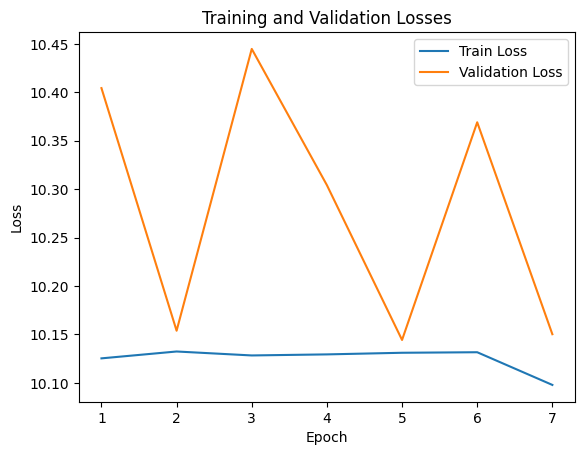

In [52]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize best_val_loss here
best_model_state = None
patience_counter = 0
early_stopping_patience = 3  # Define the patience for early stopping


EPOCHS = 20
initial_lr = 0.001  # Start with a small learning rate
lr_step_size = 6   # Update the learning rate every 6 epochs
lr_gamma = 0.1      # Multiply the learning rate by 0.1 every lr_step_size epochs
criterion = nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

train_losses = []
val_losses = []

for epoch in trange(EPOCHS):
    # Training phase
    avg_train_loss = []
    model.train()  # Set model to training mode
    for i, (image, mask) in enumerate(tqdm(train_loader)):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image).squeeze()
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        avg_train_loss.append(loss.item())

    avg_train_loss = np.mean(avg_train_loss)

    # Validation phase
    avg_val_loss = []
    model.eval()  # Set model to evaluation mode
    for j, (image, mask) in enumerate(tqdm(val_loader)):
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            output = model(image).squeeze()
            loss = criterion(output, mask)
            avg_val_loss.append(loss.item())

    avg_val_loss = np.mean(avg_val_loss)

     # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Apply learning rate scheduling
    scheduler.step()

    # Append the losses for this epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Create a DataFrame to store the losses
loss_df = pd.DataFrame({'val_loss': val_losses, 'train_loss': train_losses})

# Plot the losses
plt.plot(loss_df.index + 1, loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df.index + 1, loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## Inference

In [50]:
# Inference

# Set the model to evaluation mode
model.eval()

# Convert the test data to a tensor and move it to the appropriate device
test_tensor = torch.tensor(test.values, dtype=torch.float32).to(device)

# Make predictions on the test data
with torch.no_grad():
    predictions = model(test_tensor)

# Convert predictions tensor to numpy array
predictions_np = predictions.cpu().numpy()
predictions_np

array([10.366641, 10.366641, 10.366639, ..., 10.366639, 10.36664 ,
       10.366639], dtype=float32)

## Hyperparameter tune 

In [33]:
# Define train_model function
def train_model(params, X_train_tensor, y_train_tensor):
    input_dim = X_train_tensor.shape[1]
    hidden_dim = params['hidden_dim']
    num_heads = params['num_heads']
    num_layers = params['num_layers']
    dropout = params['dropout']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    early_stopping_patience = params['early_stopping_patience']
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = SAINTModel(input_dim, hidden_dim, num_heads, num_layers, dropout).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    best_val_rmse_folds = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold [{fold+1}/3]")

        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset = TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        best_val_rmse = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in tqdm(range(num_epochs)):
            model.train()
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_predictions = []
            val_targets = []
            
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_predictions.append(outputs.squeeze().cpu().numpy())
                    val_targets.append(batch_y.cpu().numpy())
            
            val_predictions = np.concatenate(val_predictions)
            val_targets = np.concatenate(val_targets)
            
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation RMSE: {val_rmse:.4f}")
            
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        best_val_rmse_folds.append(best_val_rmse)
        model.load_state_dict(best_model_state)
    
    avg_val_rmse = np.mean(best_val_rmse_folds)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")
    
    return avg_val_rmse

# Define objective function
def objective(trial):
    num_heads = trial.suggest_int('num_heads', 2, 8)
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    hidden_dim = int(np.ceil(hidden_dim / num_heads) * num_heads)  # Ensure hidden_dim is divisible by num_heads
    
    params = {
        'hidden_dim': hidden_dim,
        'num_heads': num_heads,
        'num_layers': trial.suggest_int('num_layers', 1, 4),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'num_epochs': 200,
        'batch_size': trial.suggest_int('batch_size', 16, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'early_stopping_patience': 10
    }
    
    avg_val_rmse = train_model(params, X_train_tensor, y_train_tensor)
    
    return avg_val_rmse


# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(multivariate=True))

# Optimize the hyperparameters
study.optimize(objective, timeout=3600 * 10)

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2024-04-17 10:48:55,867] A new study created in memory with name: no-name-acf3603f-f671-46e4-a6a3-76bfabbb80a9


Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 3.2812
Epoch [2/200], Validation RMSE: 3.2905
Epoch [3/200], Validation RMSE: 3.3525
Epoch [4/200], Validation RMSE: 3.2289
Epoch [5/200], Validation RMSE: 3.2666
Epoch [6/200], Validation RMSE: 3.2133
Epoch [7/200], Validation RMSE: 3.3253
Epoch [8/200], Validation RMSE: 3.1533
Epoch [9/200], Validation RMSE: 3.2944
Epoch [10/200], Validation RMSE: 3.3093
Epoch [11/200], Validation RMSE: 3.2599
Epoch [12/200], Validation RMSE: 3.3747
Epoch [13/200], Validation RMSE: 3.5128
Epoch [14/200], Validation RMSE: 3.3331
Epoch [15/200], Validation RMSE: 3.4589
Epoch [16/200], Validation RMSE: 3.1668
Epoch [17/200], Validation RMSE: 3.1470
Epoch [18/200], Validation RMSE: 3.2188
Epoch [19/200], Validation RMSE: 3.2065
Epoch [20/200], Validation RMSE: 3.2378
Epoch [21/200], Validation RMSE: 3.1941
Epoch [22/200], Validation RMSE: 3.3695
Epoch [23/200], Validation RMSE: 3.1847
Epoch [24/200], Validation RMSE: 3.2254
Epoch [25/200], Validation RMSE: 3.2173
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 3.3148
Epoch [2/200], Validation RMSE: 3.1949
Epoch [3/200], Validation RMSE: 3.3257
Epoch [4/200], Validation RMSE: 3.2369
Epoch [5/200], Validation RMSE: 3.2079
Epoch [6/200], Validation RMSE: 3.2105
Epoch [7/200], Validation RMSE: 3.2089
Epoch [8/200], Validation RMSE: 3.2720
Epoch [9/200], Validation RMSE: 3.1938
Epoch [10/200], Validation RMSE: 3.1938
Epoch [11/200], Validation RMSE: 3.1939
Epoch [12/200], Validation RMSE: 3.2252
Epoch [13/200], Validation RMSE: 3.1950
Epoch [14/200], Validation RMSE: 3.2083
Epoch [15/200], Validation RMSE: 3.1992
Epoch [16/200], Validation RMSE: 3.2123
Epoch [17/200], Validation RMSE: 3.2139
Epoch [18/200], Validation RMSE: 3.1946
Epoch [19/200], Validation RMSE: 3.2307
Epoch [20/200], Validation RMSE: 3.1938
Early stopping at epoch 20
Fold [3/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 3.2171
Epoch [2/200], Validation RMSE: 3.1925
Epoch [3/200], Validation RMSE: 3.1913
Epoch [4/200], Validation RMSE: 3.1897
Epoch [5/200], Validation RMSE: 3.1913
Epoch [6/200], Validation RMSE: 3.1977
Epoch [7/200], Validation RMSE: 3.1994
Epoch [8/200], Validation RMSE: 3.1953
Epoch [9/200], Validation RMSE: 3.1910
Epoch [10/200], Validation RMSE: 3.1994
Epoch [11/200], Validation RMSE: 3.2008
Epoch [12/200], Validation RMSE: 3.1995
Epoch [13/200], Validation RMSE: 3.2003


[I 2024-04-17 10:53:25,105] Trial 0 finished with value: 3.1768124103546143 and parameters: {'num_heads': 7, 'hidden_dim': 213, 'num_layers': 4, 'dropout': 0.17239747853352783, 'batch_size': 109, 'learning_rate': 0.009876622578914794}. Best is trial 0 with value: 3.1768124103546143.


Epoch [14/200], Validation RMSE: 3.1996
Early stopping at epoch 14
Average Validation RMSE across folds: 3.1768
Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.0333
Epoch [2/200], Validation RMSE: 2.0881
Epoch [3/200], Validation RMSE: 2.1129
Epoch [4/200], Validation RMSE: 2.0513
Epoch [5/200], Validation RMSE: 1.9965
Epoch [6/200], Validation RMSE: 2.0443
Epoch [7/200], Validation RMSE: 2.0235
Epoch [8/200], Validation RMSE: 1.9870
Epoch [9/200], Validation RMSE: 1.9512
Epoch [10/200], Validation RMSE: 2.1244
Epoch [11/200], Validation RMSE: 2.0926
Epoch [12/200], Validation RMSE: 1.9923
Epoch [13/200], Validation RMSE: 1.9845
Epoch [14/200], Validation RMSE: 1.9428
Epoch [15/200], Validation RMSE: 1.9398
Epoch [16/200], Validation RMSE: 2.0187
Epoch [17/200], Validation RMSE: 1.9704
Epoch [18/200], Validation RMSE: 1.9208
Epoch [19/200], Validation RMSE: 1.9448
Epoch [20/200], Validation RMSE: 1.9991
Epoch [21/200], Validation RMSE: 1.9302
Epoch [22/200], Validation RMSE: 1.9176
Epoch [23/200], Validation RMSE: 1.9926
Epoch [24/200], Validation RMSE: 1.9516
Epoch [25/200], Validation RMSE: 1.9486
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9617
Epoch [2/200], Validation RMSE: 1.9701
Epoch [3/200], Validation RMSE: 1.9643
Epoch [4/200], Validation RMSE: 1.9781
Epoch [5/200], Validation RMSE: 2.1562
Epoch [6/200], Validation RMSE: 1.9689
Epoch [7/200], Validation RMSE: 1.9630
Epoch [8/200], Validation RMSE: 1.9814
Epoch [9/200], Validation RMSE: 1.9284
Epoch [10/200], Validation RMSE: 1.9400
Epoch [11/200], Validation RMSE: 1.9281
Epoch [12/200], Validation RMSE: 1.9455
Epoch [13/200], Validation RMSE: 1.9536
Epoch [14/200], Validation RMSE: 1.9272
Epoch [15/200], Validation RMSE: 1.9523
Epoch [16/200], Validation RMSE: 1.9495
Epoch [17/200], Validation RMSE: 1.9749
Epoch [18/200], Validation RMSE: 1.9648
Epoch [19/200], Validation RMSE: 1.9525
Epoch [20/200], Validation RMSE: 1.9316
Epoch [21/200], Validation RMSE: 1.9503
Epoch [22/200], Validation RMSE: 1.9724
Epoch [23/200], Validation RMSE: 1.9133
Epoch [24/200], Validation RMSE: 1.9211
Epoch [25/200], Validation RMSE: 1.9174
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9023
Epoch [2/200], Validation RMSE: 1.8939
Epoch [3/200], Validation RMSE: 1.9123
Epoch [4/200], Validation RMSE: 1.8996
Epoch [5/200], Validation RMSE: 1.9083
Epoch [6/200], Validation RMSE: 1.9012
Epoch [7/200], Validation RMSE: 1.9089
Epoch [8/200], Validation RMSE: 1.8942
Epoch [9/200], Validation RMSE: 1.9020
Epoch [10/200], Validation RMSE: 1.9207
Epoch [11/200], Validation RMSE: 1.9277


[I 2024-04-17 11:01:34,572] Trial 1 finished with value: 1.9047857522964478 and parameters: {'num_heads': 7, 'hidden_dim': 122, 'num_layers': 4, 'dropout': 0.3672614749403933, 'batch_size': 85, 'learning_rate': 0.0012365343304592232}. Best is trial 1 with value: 1.9047857522964478.


Epoch [12/200], Validation RMSE: 1.9037
Early stopping at epoch 12
Average Validation RMSE across folds: 1.9048
Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.5078
Epoch [2/200], Validation RMSE: 2.1553
Epoch [3/200], Validation RMSE: 1.9488
Epoch [4/200], Validation RMSE: 1.9292
Epoch [5/200], Validation RMSE: 1.9331
Epoch [6/200], Validation RMSE: 1.9186
Epoch [7/200], Validation RMSE: 1.8999
Epoch [8/200], Validation RMSE: 1.9500


[W 2024-04-17 11:02:08,659] Trial 2 failed with parameters: {'num_heads': 6, 'hidden_dim': 63, 'num_layers': 4, 'dropout': 0.204700536234123, 'batch_size': 128, 'learning_rate': 0.00044585975640303765} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/2953832085.py", line 99, in objective
    avg_val_rmse = train_model(params, X_train_tensor, y_train_tensor)
  File "/tmp/ipykernel_34/2953832085.py", line 54, in train_model
    outputs = model(batch_X)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_34/3658402165.py", line 48

KeyboardInterrupt: 

### Hyperparameter search space is too long but the best results obtained were:
{'num_heads': 7, 'hidden_dim': 122, 'num_layers': 4, 'dropout': 0.3672614749403933, 'batch_size': 85, 'learning_rate': 0.0012365343304592232}. Best is trial 1 with value: 1.9047857522964478.